In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

filepaths = {
    "アンジュ・カトリーナ": "../data_collection/training/chat-ange.mp3", 
    "リゼ・ヘルエスタ": "../data_collection/training/chat-lize.mp3", 
    "戌亥とこ": "../data_collection/training/chat-toko.mp3"
}

# Parameters for mel-spectrogram
sample_rate = 22050  # Standard sample rate for Librosa. Basically equal to sample rate of the audio.
n_mels = 128         # Number of mel bands
n_fft = 2048         # Length of the FFT window -> ブログのやつでは173(分解能を11.5ms にするため！)
hop_length = 256     # Number of samples between successive frames
win_length = n_fft     # window length
segment_duration = 2  # seconds

In [2]:
spectrograms = {}

for talent_name, filepath in filepaths.items():
    # File setting
    filename = filepath.split("/")[-1]
    dist_figure = "spectrogram-figure"
    dist_matrix = "spectrogram-matrix"

    out_figure = os.path.join(dist_figure, filename.replace(".mp3", ".npy"))
    out_matrix = os.path.join(dist_matrix, filename.replace(".mp3", ".npy"))

    y, sr = librosa.load(filepath, sr = sample_rate)
    print(f"audio shape is {y.shape}, sample rate is {sr}")

    n_total = len(y)
    # 0-2, 1-3, 2-4,,,
    num_segments = int( n_total / sr ) - segment_duration + 1
    matrix_list = []
    for segment_index in range(num_segments):
        segment = y[segment_index * sr : (segment_index + segment_duration) * sr ]

        mel_spec = librosa.feature.melspectrogram(
            y=segment, 
            sr=sr, n_fft=n_fft, win_length=win_length, hop_length=hop_length)

        ## dB単位に変換
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        matrix_list.append(mel_spec_db)

    # Save to npy file.
    np.save(out_matrix, matrix_list)

    spectrograms[talent_name] = matrix_list

audio shape is (15287296,), sample rate is 22050
audio shape is (13936128,), sample rate is 22050
audio shape is (15442944,), sample rate is 22050


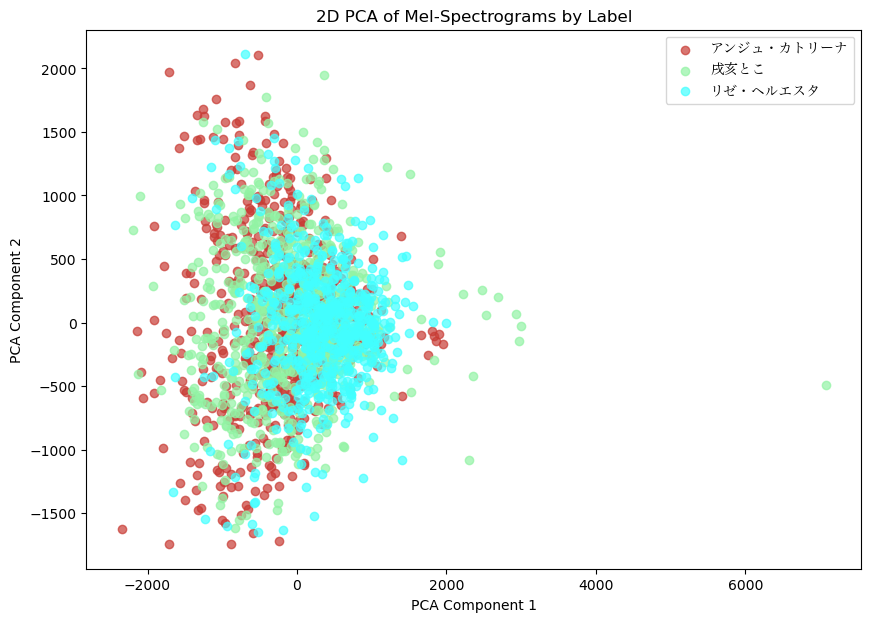

In [10]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
from data_collection import color_code
os.chdir("mel-spectrogram")

# Flatten the matrices and collect labels
flattened_data = []
labels = []

for talent_name, matrices in spectrograms.items():
    for matrix in matrices:
        flattened_data.append(matrix.flatten())
        labels.append(talent_name)

flattened_data = np.array(flattened_data)

# Apply PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(flattened_data)

# Create a scatter plot
plt.figure(figsize=(10, 7))

# Plot each point with the corresponding label color
for talent_name in set(labels):
    color = color_code.color_code_dict[talent_name]
    idx = [i for i, l in enumerate(labels) if l == talent_name]
    plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=talent_name, alpha=0.7, c=color)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Mel-Spectrograms by Label')
plt.legend(prop = {"family" : 'Hiragino Mincho ProN'})
plt.show()

(2022, 2)
692
699
631


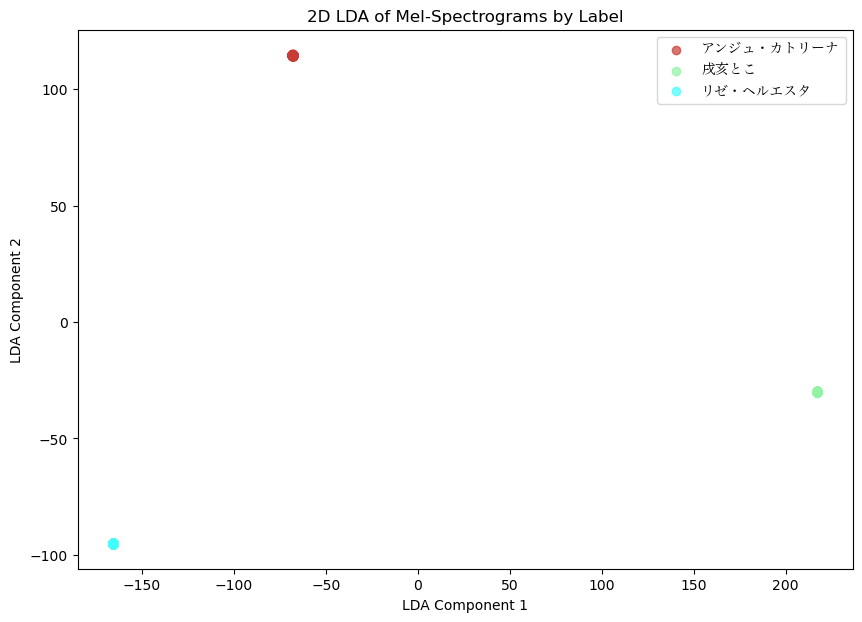

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
from data_collection import color_code
os.chdir("mel-spectrogram")

# Flatten the matrices and collect labels
flattened_data = []
labels = []

for talent_name, matrices in spectrograms.items():
    for matrix in matrices:
        flattened_data.append(matrix.flatten())
        labels.append(talent_name)

flattened_data = np.array(flattened_data)

# Apply LDA to reduce to 2 components for visualization
lda = LDA(n_components=2)
reduced_data = lda.fit_transform(flattened_data, labels)
print(reduced_data.shape)

# Create a scatter plot
plt.figure(figsize=(10, 7))

# Plot each point with the corresponding label color
for talent_name in set(labels):
    color = color_code.color_code_dict[talent_name]
    idx = [i for i, l in enumerate(labels) if l == talent_name]
    print(len(reduced_data[idx, 0]))
    plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=talent_name, alpha=0.7, c=color)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('2D LDA of Mel-Spectrograms by Label')
plt.legend(prop={"family": 'Hiragino Mincho ProN'})
plt.show()


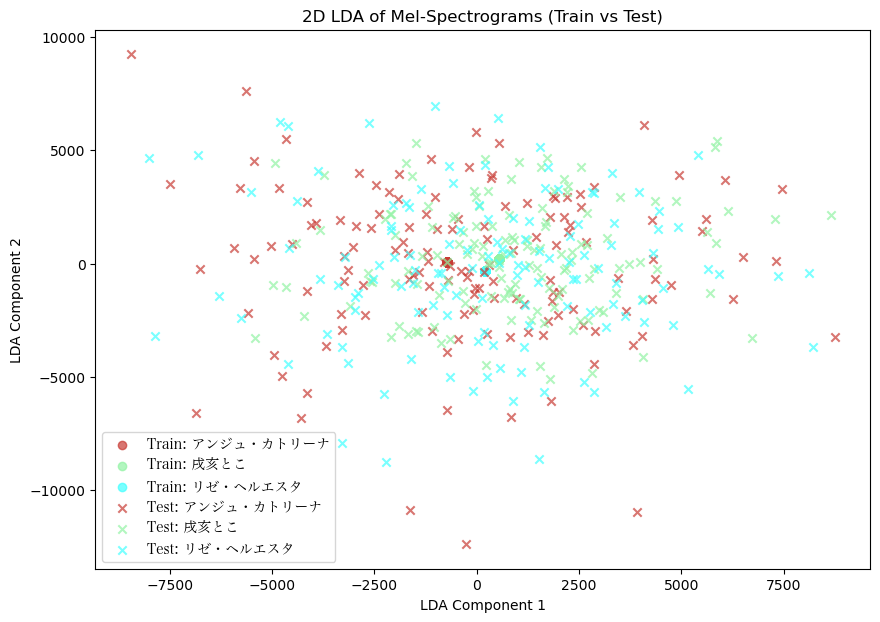

Classification accuracy on the test set: 0.40


In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
from data_collection import color_code
os.chdir("mel-spectrogram")

# Flatten the matrices and collect labels
flattened_data = []
labels = []

for talent_name, matrices in spectrograms.items():
    for matrix in matrices:
        flattened_data.append(matrix.flatten())
        labels.append(talent_name)

flattened_data = np.array(flattened_data)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(flattened_data, labels, test_size=0.2, random_state=42, stratify=labels)

# Apply LDA to reduce to 2 components for visualization
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Visualize LDA-transformed data
plt.figure(figsize=(10, 7))

# Plot training data
for talent_name in set(y_train):
    color = color_code.color_code_dict[talent_name]
    idx = [i for i, l in enumerate(y_train) if l == talent_name]
    plt.scatter(X_train_lda[idx, 0], X_train_lda[idx, 1], label=f"Train: {talent_name}", alpha=0.7, c=color, marker="o")

# Plot testing data
for talent_name in set(y_test):
    color = color_code.color_code_dict[talent_name]
    idx = [i for i, l in enumerate(y_test) if l == talent_name]
    plt.scatter(X_test_lda[idx, 0], X_test_lda[idx, 1], label=f"Test: {talent_name}", alpha=0.7, c=color, marker="x")

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('2D LDA of Mel-Spectrograms (Train vs Test)')
plt.legend(prop={"family": 'Hiragino Mincho ProN'})
plt.show()

# Train a classifier (SVM) on the LDA-transformed training data
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_lda, y_train)

# Predict on the test set
y_pred = svm.predict(X_test_lda)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy on the test set: {accuracy:.2f}")
